# 1. 사전 세팅

In [ ]:
# Warnings 제거
import warnings
warnings.filterwarnings('ignore')

%cd "/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/2. 당뇨 환자 재입원 예측 모델링"

# 2. 문제 정의

---

    당뇨병은 세계 성인 인구의 9% 이상에 영향을 미치고 있으며, 점점 더 증가하고 있다.
    당뇨 환자는 지속적인 관찰과 치료가 필요하며, 중증 환자는 더 세심한 관리가 필요하다.
    
    이를 위해 30일 이내 재입원해야하는 환자를 예측하는 모델을 생성할 것이다.
    그리고 모델 성능 향상을 위해 Error의 분포를 분석해 성능을 향상시킬 것이다.

# 3. 데이터 확인

## 3.1. 데이터 명세

---

| Column | Description |
|:----|:----|
| Features | 환자 입원 기간 내 관련 정보 |
| Class | readmit_30_days |

## 3.2. 데이터 살펴보기

In [ ]:
# openml API를 사용해 당뇨 환자 데이터 읽어오기
from sklearn.datasets import fetch_openml

df, y = fetch_openml(data_id=43874, as_frame=True, return_X_y=True)

In [ ]:
df.info()

In [ ]:
df.sample(5)

## 3.3. 데이터 가공 명세

---

| 명세 | 내용 |
|:----|:----|
| 가공 범위 | <input type="checkbox" checked> Feature(Column) 변형<br> <input type="checkbox">기간 단위 데이터 분석 및 Big Volume 특성을 반영하기 위한 데이터 증강<br> <input type="checkbox" checked>다양한 Table을 참조하기 위한 데이터 분할|
| 가공 상세 | <b>Feature(Column) 변형</b><br><br>- OnehotEncoding Transform을 통한 Feature 추가 생성<br>- 타겟에 직접적으로 관련된 변수 삭제해 모델 영향도 제거<br><br><b>데이터 분할</b><br><br>- 학습/검증을 위해 Train:Test=7:3으로 분할 |
| 가공 결과 | <b>As is</b><br><br>- row: 101766 / column: 34 / table: 1<br><br> <b>To be</b><br><br>- row: 101766 / column: 54(+20) / table: 1  |

# 4. 문제 해결 프로세스 정의

---

▸ 문제

    퇴원한 환자들 중 재입원하는 중증 환자들이 늘어나고 있다.
    
▸ 기대 효과

    재입원 환자들을 예측함으로써 중증 환자 사전 조치와 모니터링을 시행할 수 있다.
    그리고 중증 환자의 생존율이 높아질 수 있다.

▸ 해결 방안

    Binary Classification으로 30일 이내 재입원할 환자(중증 환자)들을 분류한다.
    Class Weight가 오류에 미치는 영향을 분석하고, Feature Importance까지도 알아본다.

▸ 성과 측정

    에러/Cohort 분석으로 점진적인 성능 향상 예정

▸ 현업 적용

    모델 성능 하락 시 분석 포인트 탐색

# 5. 데이터 전처리 및 EDA

## 5.1. 데이터 전처리

In [ ]:
# 필요 라이브러리 설치
!pip install lightgbm optuna shap --quiet

In [ ]:
import math
import os
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import lightgbm as lgb
import optuna

# from responsibleai import RAIInsights
# from raiwidgets import ResponsibleAIDashboard
# from raiwidgets.cohort import Cohort, CohortFilter, CohortFilterMethods
# Numpy 때문에 호환이 안 된다...
# import shap

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

### 5.1.1. Target 유의 변수 제거

In [ ]:
df['readmitted'].value_counts()

| readmitted | count |
|:---:|:----|
| NO | 54864 |
| >30 | 35545 |
| <30 | 11357 |



In [ ]:
df['readmit_binary'].value_counts()

| readmit_binary | count |
|:---:|:----|
| 0 | 54864 |
| 1 | 46902 |

In [ ]:
# 실제 타겟
y.value_counts()

| readmit_30_days | count |
|:---:|:----|
| 0 | 90409 |
| 1 | 11357 |

---

    실제 타겟에서 30일 이내 재입원 한 사람(1)은 11357명,
    30일 이상 재입원 + 비재입원한 사람(0)은 90409명이다.



```
위에서도 알 수 있듯, 2개의 변수는 y와 직접적으로 상관 관계가 보이기 때문에 학습 Feature로 사용할 수 없다.
y와 직접적으로 상관 관계가 있는 변수들을 Feature로 사용할 경우, 모든 경우 100%에 가까운 정확도를 보이게 되며,
이는 정답을 보여주는 것과 동일하기에 정상적인 모델이라고 할 수 없다.
```



### 5.1.2. 인코딩

In [ ]:
# 함수 정의
def transform_data(X_):
    # 변수 제거
    X = X_.drop(['readmitted', 'readmit_binary'], axis=1)

    # 바이너리 인코딩
    bool_cols = X.select_dtypes(include='category').columns.tolist()
    X[bool_cols] = X[bool_cols].astype(str).replace({'True':1, 'False':0})
    print(bool_cols)

    # 원핫 인코딩
    cat_cols = X.select_dtypes(include='object').columns.tolist()
    print(cat_cols)

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder_np = encoder.fit_transform(X[cat_cols].astype('category'))
    X[encoder.get_feature_names_out(cat_cols)] = encoder_np.astype(int)

    # 원본 열 제거
    X.drop(cat_cols, axis=1, inplace=True)

    return X

In [ ]:
X = transform_data(df)



```
['medicare', 'medicaid', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']
['race', 'gender', 'age', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'primary_diagnosis', 'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed']
```



In [ ]:
print(f'원본 데이터 Feature 수: {len(df.columns)}')
print(df.columns)



```
원본 데이터 Feature 수: 24
Index(['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'primary_diagnosis', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'insulin', 'change', 'diabetesMed', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'readmitted', 'readmit_binary'],
      dtype='object')
```



In [ ]:
print(f'변환 데이터 Feature 수: {len(X.columns)}')
print(X.columns)



```
변환 데이터 Feature 수: 54
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'medicare', 'medicaid',
       'had_emergency', 'had_inpatient_days', 'had_outpatient_days',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_Unknown', 'gender_Female', 'gender_Male',
       'gender_Unknown/Invalid', 'age_'30 years or younger'',
       'age_'30-60 years'', 'age_'Over 60 years'',
       'discharge_disposition_id_'Discharged to Home'',
       'discharge_disposition_id_Other', 'admission_source_id_Emergency',
       'admission_source_id_Other', 'admission_source_id_Referral',
       'medical_specialty_Cardiology', 'medical_specialty_Emergency/Trauma',
       'medical_specialty_Family/GeneralPractice',
       'medical_specialty_InternalMedicine', 'medical_specialty_Missing',
       'medical_specialty_Other', 'primary_diagnosis_'Genitourinary Issues'',
       'primary_diagnosis_'Musculoskeletal Issues'',
       'primary_diagnosis_'Respiratory Issues'', 'primary_diagnosis_Diabetes',
       'primary_diagnosis_Other', 'max_glu_serum_>200', 'max_glu_serum_>300',
       'max_glu_serum_None', 'max_glu_serum_Norm', 'A1Cresult_>7',
       'A1Cresult_>8', 'A1Cresult_None', 'A1Cresult_Norm', 'insulin_Down',
       'insulin_No', 'insulin_Steady', 'insulin_Up', 'change_Ch', 'change_No',
       'diabetesMed_No', 'diabetesMed_Yes'],
      dtype='object')
```



## 5.2. 데이터셋 분할

In [ ]:
rand = 42
os.environ['PYTHONHASHSEED'] = str(rand)
np.random.seed(rand)

In [ ]:
label = ['NO or > 30 days', '< 30 days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand)
df_test = df.loc[X_test.index]

In [ ]:
# 71236 rows × 54 columns
X_train

In [ ]:
# 30530 rows × 54 columns
X_test

## 5.3. 모델 Evaluation 함수 정의

---

    모델을 생성하면 성능에 대한 평가를 하기 위해 evalutaion 함수를 정의하고 시작하는 것이 좋다.

In [ ]:
# Accuracy, Precision, Recall, F1 score를 도출하고, Confusion Matrix 시각화하는 함수
def evaluate_class(fitted_model, X_train, X_test, y_train, y_test, plot=True, pct=True, thresh=0.5):
    # 2차원인 것들도 1차원으로 쭉 늘려주는 squeeze 함수
    y_train_pred = fitted_model.predict(X_train).squeeze()

    # 이진 분류가 되지 않았다면(모델이 연속 확률값(0.7, 0.1) 등을 반환했다면)
    if len(np.unique(y_train_pred)) > 2:
        # thresh에 따라 이진 분류 다시 해주기
        y_train_pred = np.where(y_train_pred > thresh, 1, 0)
        y_test_prob = fitted_model.predict(X_test).squeeze()
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)
    else:
        y_test_prob = fitted_model.predict_proba(X_test)[:, 1]
        y_test_pred = np.where(y_test_prob > thresh, 1, 0)

    roc_auc_test = metrics.roc_auc_score(y_test, y_test_prob)

    cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cf_matrix.ravel()

    acc_train = metrics.accuracy_score(y_train, y_train_pred)
    acc_test = metrics.accuracy_score(y_test, y_test_pred)

    pre_test = metrics.precision_score(y_test, y_test_pred)

    rec_test = metrics.recall_score(y_test, y_test_pred)
    f1_test = metrics.f1_score(y_test, y_test_pred)

    mcc_test = metrics.matthews_corrcoef(y_test, y_test_pred)

    if plot:
        print(f'Accuracy Train: {acc_train:.4f}\t\tAccuracy Test: {acc_test:.4f}')
        print(f'Precision Test: {pre_test:.4f}\t\tRecall Test: {rec_test:.4f}')
        print(f'ROC-AUC Test: {roc_auc_test:.4f}\t\tF1 Test: {f1_test:.4f}\t\tMCC Test: {mcc_test:.4f}')

        plt.figure(figsize=(6, 5))

        if pct:
            ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
                             fmt='.2%', cmap='Blues', annot_kws={'size':16})
        else:
            ax = sns.heatmap(cf_matrix, annot=True,
                             fmt='d', cmap='Blues', annot_kws={'size':16})

        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('Observed', fontsize=12)
        plt.show()

        return y_train_pred, y_test_prob, y_test_pred

    else:
        t = cf_matrix.sum()
        metrics_dict = {'accuracy_train': acc_train, 'accuracy_test': acc_test, 'precision': pre_test,
                        'recall': rec_test, 'roc_auc': roc_auc_test, 'f1': f1_test,
                        'tn%': tn/t, 'fp%': fp/t, 'fn%': fn/t, 'tp%': tp/t}

        return metrics_dict

# 6. 모델 학습

## 6.1. LightGBM Classifier 모델 학습

In [ ]:
# LightGBMClassifier
%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1)
clf.fit(X_train, y_train)

_ = evaluate_class(clf, X_train, X_test, y_train, y_test)



```
Accuracy Train: 0.8888		Accuracy Test: 0.8877
Precision Test: 0.0000		Recall Test: 0.0000
ROC-AUC Test: 0.6469		F1 Test: 0.0000		MCC Test: -0.0029
```

    숫자만 봤을 때는 정확도가 매우 높은 것으로 보이지만, Precision과 Recall이 매우 낮아 전반적인 성능은 나쁘다.
    중증 환자의 케이스가 10% 정도라 중증 환자는 없다고 모델이 판단한 것이다.



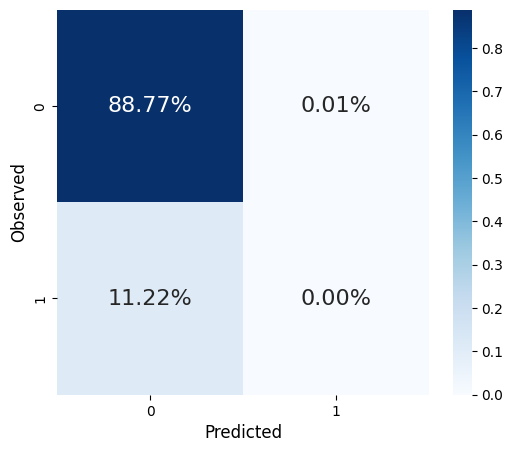

    기본적으로 모델은 예측 시 불확실한 샘플에 대해 Positive(1)보다는 Negative(0)으로 분류하는 경향을 보인다.
    이는 False Positive보다 False Negative를 덜 위험하게 판단하는 보수적인 의사결정 기준 때문이다.

    하지만 의료 분야에서는 Positive 클래스(중증 환자)를 놓치는 것이 더 큰 위험이므로,
    Positive 클래스의 중요도를 높이는 방향으로 학습을 유도할 필요가 있다.

    이를 위해 LightGBM의 scale_pos_weight 파라미터를 활용해서 Positive 클래스의 손실을 더 크게 반영하도록 조정할 예정이다.

### 6.1.1. 클래스 가중치 부여

In [ ]:
def_scale_pos_weight = len(y[y==0]) / len(y[y==1])
print(f'Default scale pos weight: {def_scale_pos_weight:.2f}')



```
Default scale pos weight: 7.96
```



In [ ]:
# 해당 비율을 적용하여 다시 모델 학습
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight)
clf.fit(X_train, y_train)
_ = evaluate_class(clf, X_train, X_test, y_train, y_test)



```
Accuracy Train: 0.6381		Accuracy Test: 0.6086
Precision Test: 0.1638		Recall Test: 0.6064
ROC-AUC Test: 0.6458		F1 Test: 0.2580		MCC Test: 0.1379
```



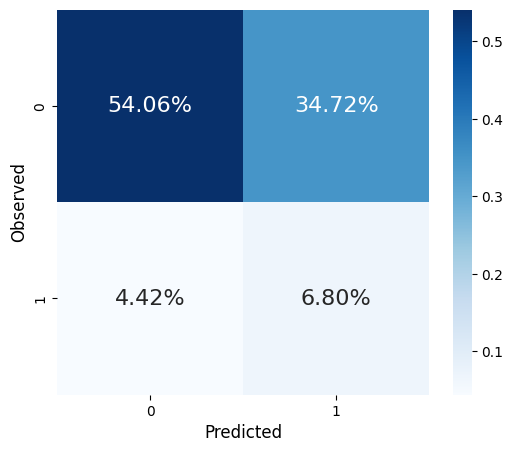

    실제로 모델 성능은 향상되었으나 여전히 상당 수준의 오탐지가 존재한다.

In [ ]:
# 그리고 두 배로 그 비율을 늘리게 되면 오탐지도 똑같이 두 배
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight*2)
clf.fit(X_train, y_train)
_ = evaluate_class(clf, X_train, X_test, y_train, y_test)



```
Accuracy Train: 0.3354		Accuracy Test: 0.3157
Precision Test: 0.1293		Recall Test: 0.8893
ROC-AUC Test: 0.6438		F1 Test: 0.2258		MCC Test: 0.0997
```



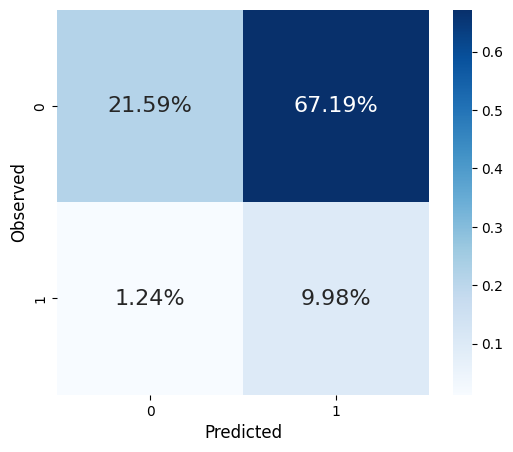

In [ ]:
# 그리고 해당 비율을 반으로 줄이게 되면 모델이 조금 보수적으로 변함
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, scale_pos_weight=def_scale_pos_weight/2)
clf.fit(X_train, y_train)
_ = evaluate_class(clf, X_train, X_test, y_train, y_test)



```
Accuracy Train: 0.8771		Accuracy Test: 0.8617
Precision Test: 0.2232		Recall Test: 0.0937
ROC-AUC Test: 0.6485		F1 Test: 0.1320		MCC Test: 0.0782
```



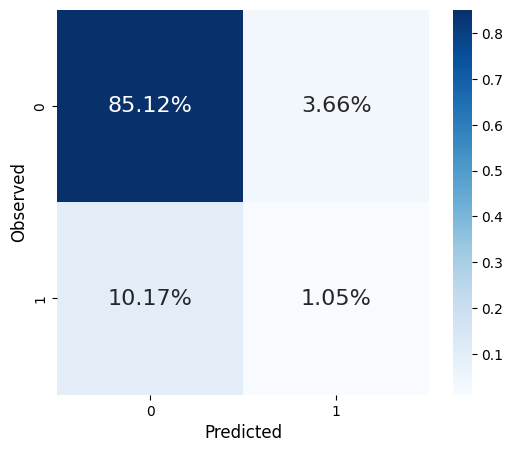

### 6.1.2. Hyperparameter tuning

---

    실무에서는 다음과 같은 성향의 모델이 요구된다.

    - True Positive(정탐; 실제 재입원/예측 재입원)을 최대화하여 실제 재입원 환자를 놓치지 않아야 한다.
    - False Negative(미탐; 실제 재입원/예측 재입원 안 함)을 최소화하고, 약간의 False Positive(오탐; 실제 재입원 안 함/예측 재입원)은 감수할 수 있다.
    - 정확도(Accuracy)보다는 재현율(Recall)과 정밀도(Precision)의 균형을 더 중시한다.
    - 즉, 미탐을 최소화하기 위해 오탐이 다소 많아지는 방향을 선호한다.
    - 미탐이 늘어나면 중증 환자인데 재입원을 놓칠 수도 있어 위험하다.

    - 그러나 현재 모델은 지나치게 보수적이어서 대부분의 환자를 0으로 예측하며, 실제 적용에는 한계가 있다.

---

    현재 모델의 결과를 보면, 대부분의 환자를 30일 이후 입원했거나 비입원한 환자로 예측하고 있다.
    이를 개선하기 위해, Positive 클래스(30일 이내 재입원)에 대한 예측 비율을 일정 수준 이상 확보하도록 제약을 두었다.
    최소한의 True Positive 비율을 유지하면서 False Negative를 줄이는 방향으로 학습을 조정하였다.

In [ ]:
min_tn = df[df['readmitted'] == 'NO'].shape[0] / df.shape[0]
print(f'Baseline accuracy if predicting all patients as non-readmitted: {min_tn:.2%}')

    현재 모델은 30일 이내 재입원만 Positive로 보지만,
    실제로는 30일 이후 재입원한 환자들도 건강 상태가 나빠지는 추세에 있다는 점에서 ‘완전히 틀린 예측(False Positive)’으로만 볼 수는 없다.
    따라서 이 비율(>30)을 조정하여 모델이 조기 경고 신호를 감지하도록 유도하자.

In [ ]:
max_fp = df[df['readmitted'] == '>30'].shape[0] / df.shape[0]
print(f'Patients % readmitted over 30 days later (Potential future-risk group): {max_fp:.2%}')

### 6.1.3. 모델 최적화

---

    함수에서 scale_pos_weight를 사용한 클래스 가중치 외에도 max_depth(트리 깊이 제한) 및 reg_lambda, reg_alpha를 사용해
    L1/L2 정규화에 대한 최적의 하이퍼파라미터를 찾을 수 있다.
    목적 함수는 두 제약 조건이 충족되지 않는 경우를 제외하고 recall을 출력하도록 구현

In [ ]:
def optimize_lgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 11),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', def_scale_pos_weight/2, def_scale_pos_weight*2),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True)
    }

    if params['max_depth'] == 11:
        params['max_depth'] = -1

    clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, **params)
    clf.fit(X_train, y_train)

    metrics_dict = evaluate_class(clf, X_train, X_test, y_train, y_test, plot=False)

    if (metrics_dict['tn%'] < min_tn) or (metrics_dict['fp%'] > max_fp):
        return 0

    return metrics_dict['recall']

In [ ]:
%%time
opt_study = optuna.create_study(direction='maximize')
opt_study.optimize(optimize_lgb, n_trials=100)

In [ ]:
best_params = opt_study.best_params
print(best_params)



```
{'max_depth': 9, 'scale_pos_weight': 7.938839956757194, 'reg_lambda': 0.0003484367085447318, 'reg_alpha': 8.289038320600987e-08}
```



### 6.1.4. 최적화된 파라미터로 다시 학습

In [ ]:
best_params = {'max_depth': 9, 'scale_pos_weight': 7.938839956757194,
               'reg_lambda': 0.0003484367085447318, 'reg_alpha': 8.289038320600987e-08}

%matplotlib inline
clf = lgb.LGBMClassifier(random_state=rand, n_jobs=-1, **best_params)
clf.fit(X_train, y_train)

_, y_prob, y_pred = evaluate_class(clf, X_train, X_test, y_train, y_test)



```
Accuracy Train: 0.6358		Accuracy Test: 0.6121
Precision Test: 0.1672		Recall Test: 0.6172
ROC-AUC Test: 0.6473		F1 Test: 0.2631		MCC Test: 0.1465
```



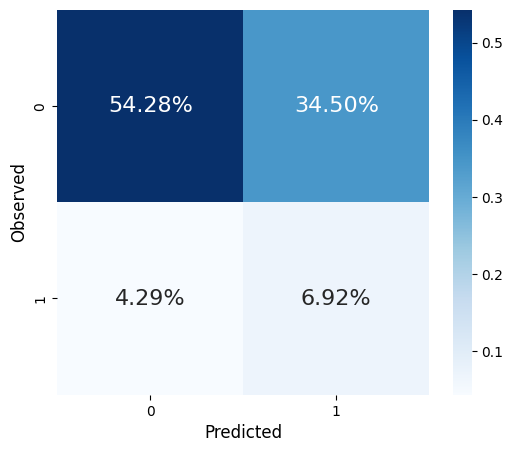

# 7. 에러 분석

---

    Confusion Matrix 분석 결과, 전체 예측 정확도는 약 61.2%였으며, 비재입원(0)으로 예측한 비율이 매우 높았다(88.8%).

    재입원을 예측하지 못한 FN 비율은 4.3%로 상대적으로 작지만,
    이 경우 실제 중증 환자를 놓치는 문제가 발생해 의료 비용 측면에서 심각한 영향을 줄 수 있다.

    반면 재입원으로 잘못 예측한 FP가 34.5%로, 불필요한 관리 자원 낭비를 초래할 수 있다.

    따라서 모델은 전반적으로 30일 이내 재입원을 과소예측하는 경향을 보이며, Recall 향상이 필요한 상태이다.

In [ ]:
df_test['readmitted'].value_counts()

In [ ]:
preds_df = pd.DataFrame({'readmitted':df_test['readmitted'],
                         'y_true':y_test.astype(int),
                         'y_pred':y_pred})

# 실제로는 재입원이 아닌데(0) 모델이 재입원(1)이라고 예측한 사례들의 분포(FP)를 구하는 것
preds_df[(preds_df.y_true == 0) & (preds_df.y_pred == 1)].value_counts(normalize=True)

| readmitted | y_true | y_pred | proportion |
|:---:|:----:|:----:|:----:|
| NO | 0 | 1 | 0.50432 |
| >30 | 0 | 1 | 0.49568 |

---

    34.5%의 절반이 실제로 재입원을 안 했고, 나머지 절반이 '>30'로 나타났다.

    전체의 약 17%는 30일 이후 재입원한 사례로, 완전한 오탐이 아니라 조기 위험 신호로 해석할 수 있다.
    결국 개선해야 할 진정한 오탐은, 재입원이 없었던 나머지 절반의 사례들이다.

## 7.1. 에러를 그룹별로 나누기

In [ ]:
# 에러를 그룹별로 비교하기 위한 함수들
def set_header_font():
    return [dict(selector='th', props=[('font-size', '14pt')])]

def metrics_by_group(s):
    accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
    precision = metrics.precision_score(s.y_true, s.y_pred) * 100
    recall = metrics.recall_score(s.y_true, s.y_pred) * 100
    f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
    roc_auc, fnr, fpr = np.nan, np.nan, np.nan

    if len(np.unique(s.y_true)) == 2:
        roc_auc = metrics.roc_auc_score(s.y_true, s.y_prob) * 100
        tn, fp, fn, tp = metrics.confusion_matrix(s.y_true, s.y_pred).ravel()
        fnr = (fn/(tp+fn)) * 100
        fpr = (fp/(tn+fp)) * 100

    support = len(s.y_true)

    return pd.Series((support, accuracy, precision, recall, f1, roc_auc, fnr, fpr),
                     index=['support', 'accuracy', 'precision', 'recall', 'f1', 'roc-auc', 'fnr', 'fpr'])

def error_breakdown_by_group(mdl, y_true, y_prob, y_pred, orig_df, group_col, exclude_groups=None):
    print(f"Error breakdown for group '{group_col}'")

    predict_df = pd.DataFrame({group_col: orig_df[group_col].tolist(),
                              'y_true': y_true,
                              'y_pred': y_pred,
                              'y_prob': y_prob}, index=y_true.index)

    if exclude_groups is not None:
        predict_df = predict_df[~predict_df[group_col].isin(exclude_groups)]

    group_metrics_df = predict_df.groupby([group_col]).apply(metrics_by_group)

    html = group_metrics_df.sort_values(by='support', ascending=False).style.\
           format({'support':'{:,.0f}', 'accuracy':'{:.1f}%', 'precision':'{:.1f}%', 'recall':'{:.1f}%',
                   'f1':'{:.1f}%', 'roc-auc':'{:.1f}%', 'fnr':'{:.1f}%', 'fpr':'{:.1f}%'}).\
           set_properties(**{'font-size': '13pt'}).set_table_styles(set_header_font()).\
           highlight_max(subset=['accuracy', 'precision', 'recall', 'f1', 'roc-auc']).\
           highlight_min(subset=['fnr', 'fpr'])

    return html

def compare_confusion_matrices(y_true_1, y_pred_1, y_true_2, y_pred_2, group_1, group_2,
                               plot=True, compare_fpr=False):

    conf_matrix_1 = metrics.confusion_matrix(y_true_1, y_pred_1)
    conf_matrix_2 = metrics.confusion_matrix(y_true_2, y_pred_2)

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        sns.heatmap(conf_matrix_1 / np.sum(conf_matrix_1), annot=True,
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[0])
        ax[0].set_title(group_1 + ' Confusion Matrix', fontsize=14)
        ax[0].set_xlabel('Predicted', fontsize=12)
        ax[0].set_ylabel('Observed', fontsize=12)

        sns.heatmap(conf_matrix_2 / np.sum(conf_matrix_2), annot=True,
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[1])
        ax[1].set_title(group_2 + ' Confusion Matrix', fontsize=14)
        ax[1].set_xlabel('Predicted', fontsize=12)
        ax[1].set_ylabel('Observed', fontsize=12)
        plt.show()

## 7.2. 그룹별 에러 분석

### 7.2.1. 몇 가지 인구 통계 정보를 통한 분석 (나이)

---

    30대 이하 그룹은 잘 맞는 것으로 보인다.

In [ ]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=df_test, group_col='age')

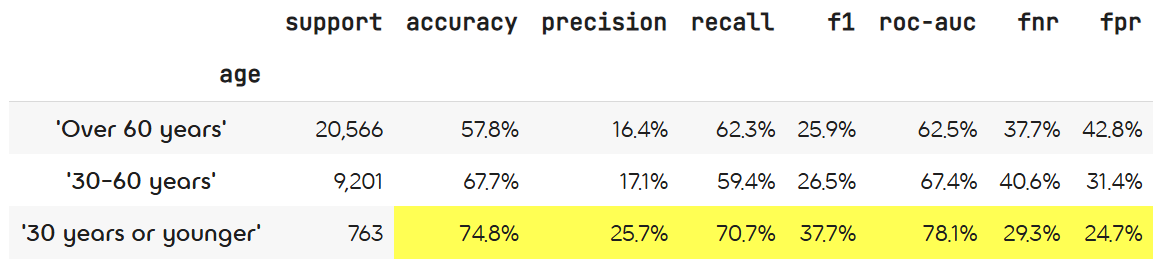

### 7.2.2. 성별에 따른 분석

---

    남녀 차이는 크게 유의미하지 않다는 것을 알 수 있다.

In [ ]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred, orig_df=df_test, group_col='gender',
                         exclude_groups=['Unknown/Invalid'])

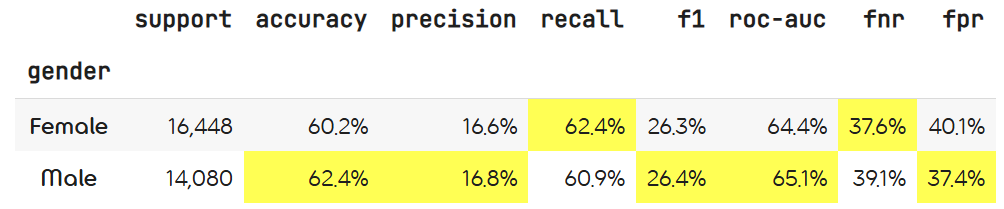

In [ ]:
_ = compare_confusion_matrices(y_test[X_test['gender_Male'] == 1], y_pred[X_test['gender_Male'] == 1],
                               y_test[X_test['gender_Female'] == 1], y_pred[X_test['gender_Female'] == 1],
                               'Male', 'Female')

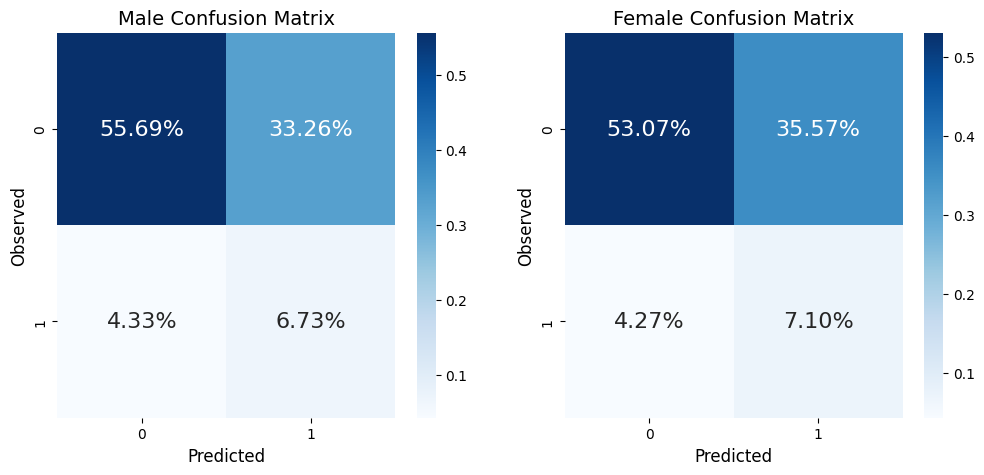

### 7.2.3. 몇 가지 의학적 특징을 통한 분석

In [ ]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred,
                         orig_df=df_test, group_col='admission_source_id')

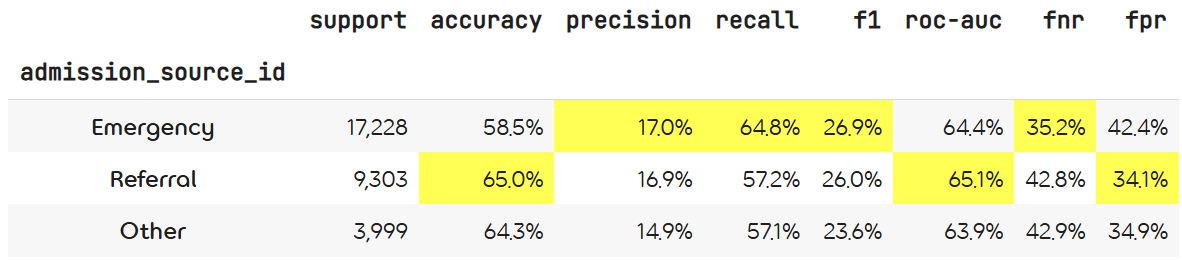

In [ ]:
error_breakdown_by_group(clf, y_true=y_test, y_prob=y_prob, y_pred=y_pred,
                         orig_df=df_test, group_col='had_inpatient_days')

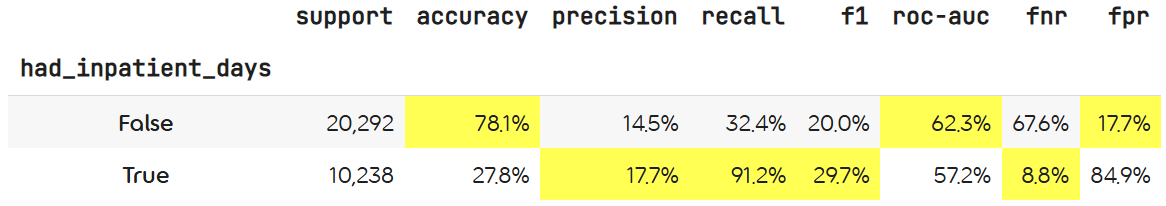

In [ ]:
_ = compare_confusion_matrices(y_test[X_test['had_inpatient_days'] == 0], y_pred[X_test['had_inpatient_days'] == 0],
                               y_test[X_test['had_inpatient_days'] == 1], y_pred[X_test['had_inpatient_days'] == 1],
                               'No Inpatient Days', 'Inpatient Days', compare_fpr=True)

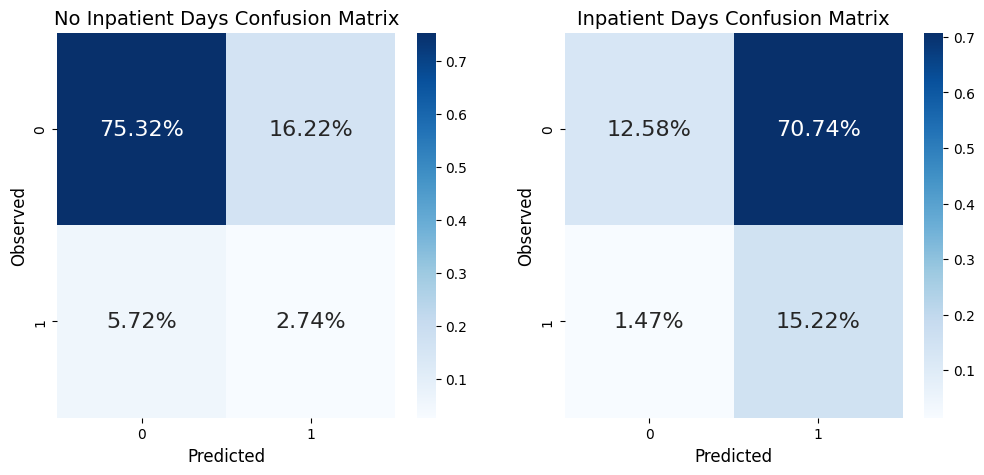

    had_inpatient_days에 따라 잘 맞추긴 하지만, 틀리는 비율도 많다...
    그래도 유의미한 변수인 것은 분명하다..!

In [ ]:
_ = compare_confusion_matrices(y_test[(X_test['had_inpatient_days'] == 0) & (df_test['readmitted'] != '>30')],
                               y_pred[(X_test['had_inpatient_days'] == 0) & (df_test['readmitted'] != '>30')],
                               y_test[(X_test['had_inpatient_days'] == 1) & (df_test['readmitted'] != '>30')],
                               y_pred[(X_test['had_inpatient_days'] == 1) & (df_test['readmitted'] != '>30')],
                               'No Inpatient Days w/o >30', 'Inpatient Days w/o >30', compare_fpr=True)

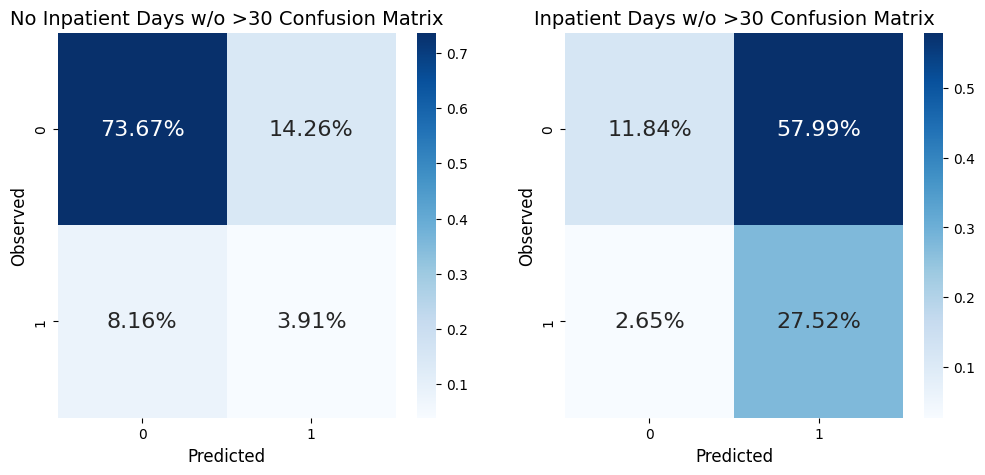